In [ ]:
!pip install nltk
!pip install emoji

import json
import os
import emoji

import nltk
import string
import re

from collections import Counter
from collections import defaultdict
import matplotlib.pyplot as plt

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk import FreqDist
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
#from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
russian_stopwords = set(stopwords.words('russian'))

import spacy

!python -m spacy download ru_core_news_sm

nlp_ru = spacy.load("ru_core_news_sm")

lemmatizer_ru = nlp_ru.get_pipe("lemmatizer")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 11.7 MB/s eta 0:00:00


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 74.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
file_path = 'result.json'

with open(file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

docs = [message['text_entities'] for message in data.get('messages')]

msgs = [[ent['text'].replace('\n\n', ' ')  for ent in msg_ent] for msg_ent in docs if msg_ent]

def no_s(msg):
  def no_s(text):
        return not (text.startswith('Фото'))
  return list(filter(not_s, msg))

corp = [''.join(no_s(msg)) for msg in msgs]

small_corp = [msg for msg in corp if len(msg)>100]

In [ ]:
def clean_bad_tokens(tokens):
    banned = {
        'подписывайся', 'подробнее', 'telegram', 'max',
        'whatsapp', 'вк', 'аств', 'прислать', 'новость',
        'нашем', 'сайте', 'astv', 'из-за', 'это', 'http',
        'https'
    }
    return [
        t for t in tokens
        if t not in banned
        and len(t) > 2
        and not t.startswith('фото')
    ]

def preprocess_texts(texts):
    clean_texts = []
    stop_words = set(stopwords.words('russian'))
    punkt = set(string.punctuation)
    bad_words = punkt | stop_words
    for text in texts:
        text = text.lower()
        text = re.sub(r'[©®™℠]+', ' ', text)
        text = re.sub(r'(\w)-(\w)', r'\1HYPHEN\2', text)
        text = re.sub(r'[^\w\sHYPHEN]', ' ', text)
        text = re.sub(r'HYPHEN', '-', text)
        text = re.sub(r'\([^)]*\)', ' ', text)
        text = re.sub(r'https?://\S+', '', text)
        text = re.sub(r'http?://\S+', '', text)
        text = text.replace('ё', 'е')
        text = re.sub(r'\b\d+\b', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()

        tokens = re.findall(r'[а-яё]+(?:-[а-яё]+)*', text)
        tokens = [token for token in tokens if token not in bad_words]
        tokens = clean_bad_tokens(tokens)

        doc = nlp_ru(" ".join(tokens))
        lemmas = [token.lemma_ for token in doc if token.lemma_ != "" and not token.is_punct and not token.is_space]
        clean_texts.append(' '.join(lemmas))

    return clean_texts

In [ ]:
russian_texts = preprocess_texts(small_corp)
print(len(russian_texts))

10578


In [ ]:
raw_text = '/n'.join(russian_texts)
one_text = re.sub(r'[^\w\s]', '', raw_text).split()

In [ ]:
#Создание n-граммной модели
def create_ngram_model(tokens, n=2):
    n_grams = list(nltk.ngrams(tokens, n))
    n_gram_counts = Counter(n_grams)

    context_counts = defaultdict(int)
    for n_gram in n_grams:
        context = n_gram[:-1]
        context_counts[context] += 1

    n_gram_model = {}
    for n_gram, count in n_gram_counts.items():
        context = n_gram[:-1]
        word = n_gram[-1]
        n_gram_model[n_gram] = count / context_counts[context]

    return n_gram_model, n_gram_counts, context_counts

#Визуализация самых частых n-грамм
def visualize_top_ngrams(n_gram_counts, n=10, title='Топ n-грамм'):
    top_n_grams = n_gram_counts.most_common(n)

    labels = [' '.join(n_gram) for n_gram, _ in top_n_grams]
    values = [count for _, count in top_n_grams]

    # Создание графика
    plt.figure(figsize=(8, 12))
    plt.barh(labels, values, color='grey')
    plt.xlabel('Частота')
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [ ]:
# Создадание уни/би/триграммных моделей
russian_unigram_model, russian_unigram_counts, russian_unigram_context_counts = create_ngram_model(one_text, 1)
russian_bigram_model, russian_bigram_counts, russian_bigram_context_counts = create_ngram_model(one_text, 2)
russian_trigram_model, russian_trigram_counts, russian_trigram_context_counts = create_ngram_model(one_text, 3)

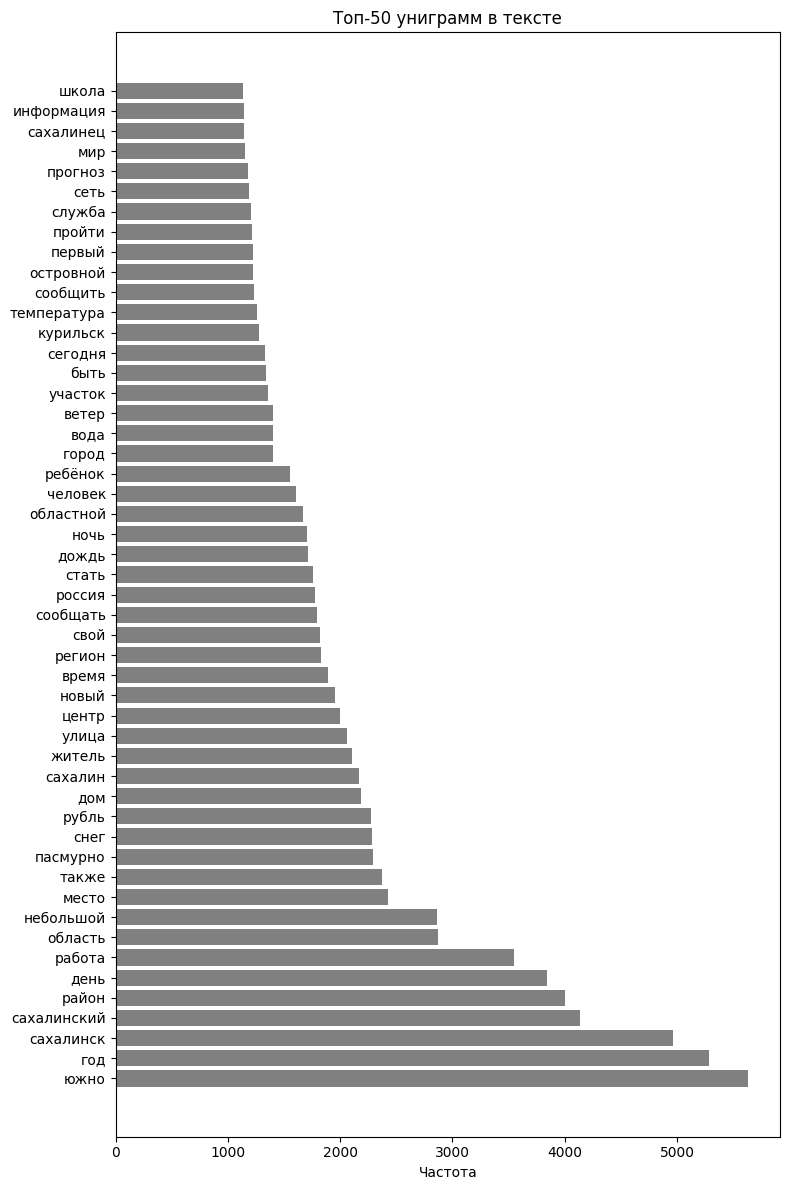

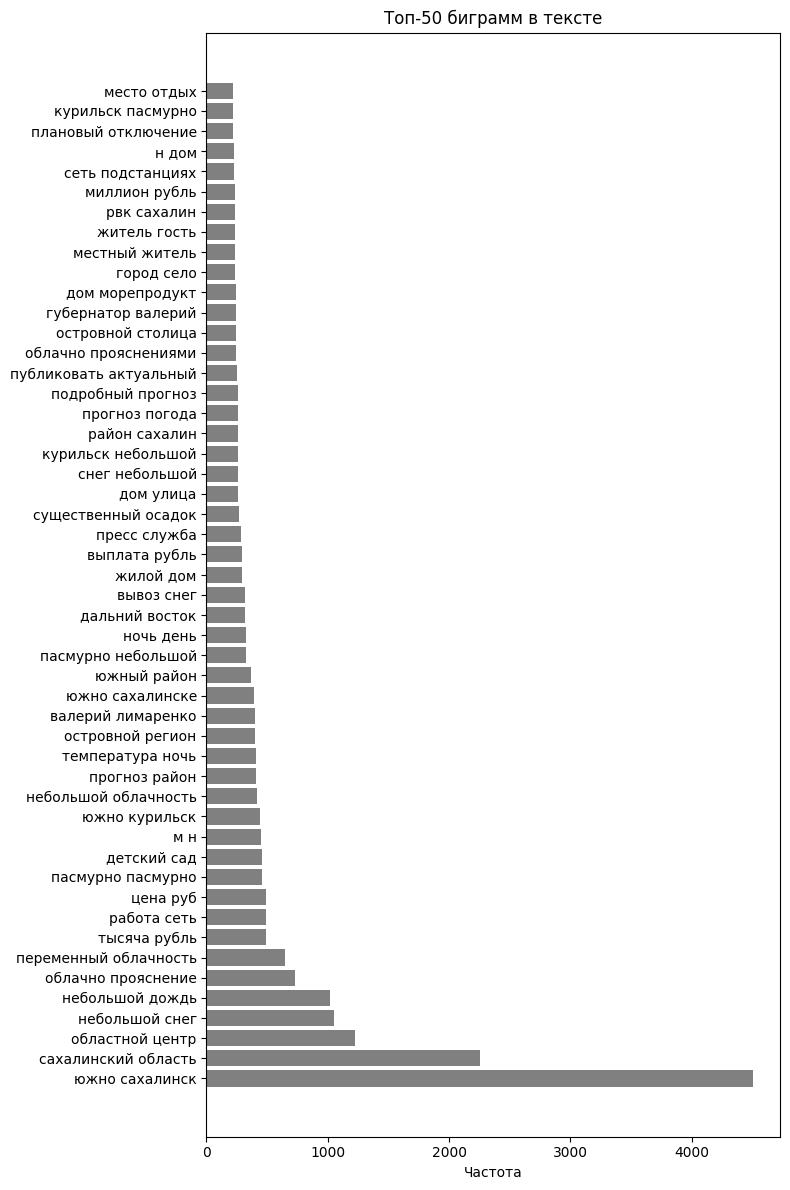

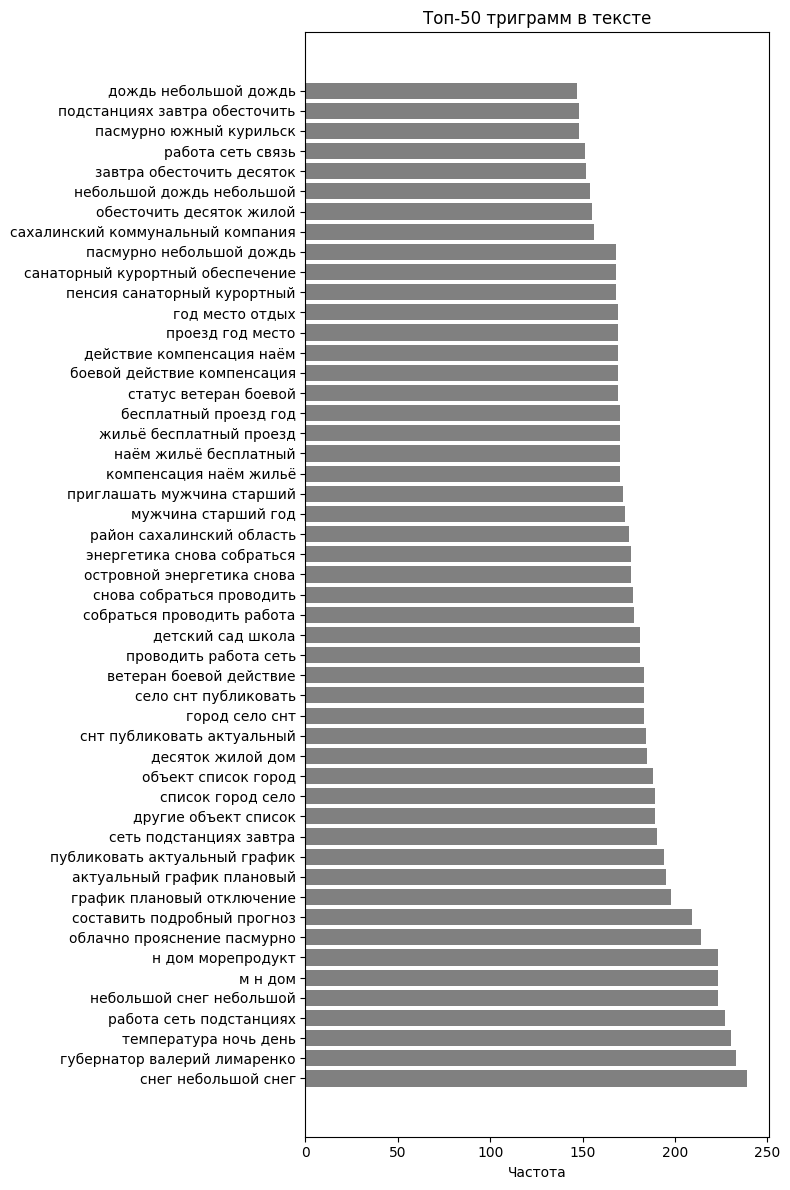

In [ ]:
# Визуализация
visualize_top_ngrams(russian_unigram_counts, title='Топ-50 униграмм в тексте', n=50)
visualize_top_ngrams(russian_bigram_counts, title='Топ-50 биграмм в тексте', n=50)
visualize_top_ngrams(russian_trigram_counts, title='Топ-50 триграмм в тексте', n=50)